In [44]:
try:
     from dlroms import*
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

import numpy as np

## **Steady Navier-Stokes equations**: leakage detection in a water reservoir

In [45]:
# FOM discretization
import gdown
gdown.download(id = "1PrQyfLv3Sjv8oOgZk48MR-miDAq0X4pO", output = "leak_mesh.xml")
mesh = fe.loadmesh("leak_mesh.xml")
Vh = fe.space(mesh, 'CG', 1)
clc()

In [46]:
# Dataset (parameters and pressure fields)
gdown.download(id = "1eEtqZPjLe3xPed15ckTAGNBYDQ8px8aJ", output = "leak_data.npz")
clc()
dataset = np.load("leak_data.npz")
mu, pressure = dataset['mu'], dataset['u']

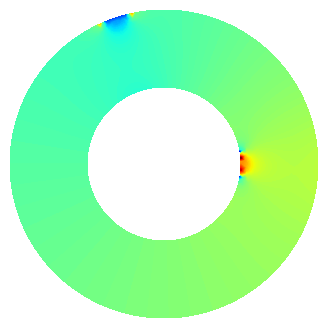

In [47]:
# Plot of the first simulation in the dataset
plt.figure(figsize = (4, 4))
fe.plot(pressure[0], Vh)

In [48]:
# Pressure measurements for the inverse problem
gdown.download(id = "1STu-gV96oB4Gqtv-kf9aenXODqJ7kdIq", output = "sensor_measurements.npz")
clc()

measurements = np.load("sensor_measurements.npz")
sensors_location, sensors_values = measurements['sensor_indices'], measurements['pressure_measurements']

In [49]:
# Example of matching between measurements and data

possible_values = pressure[0, sensors_location] # sensor values expected if the pressure field was the one in the first simulation
discrepancy = np.sum((possible_values - sensors_values)**2)
discrepancy

np.float64(0.059697524234095176)

In [50]:
mu.shape,pressure.shape
print(possible_values[0].shape)

()


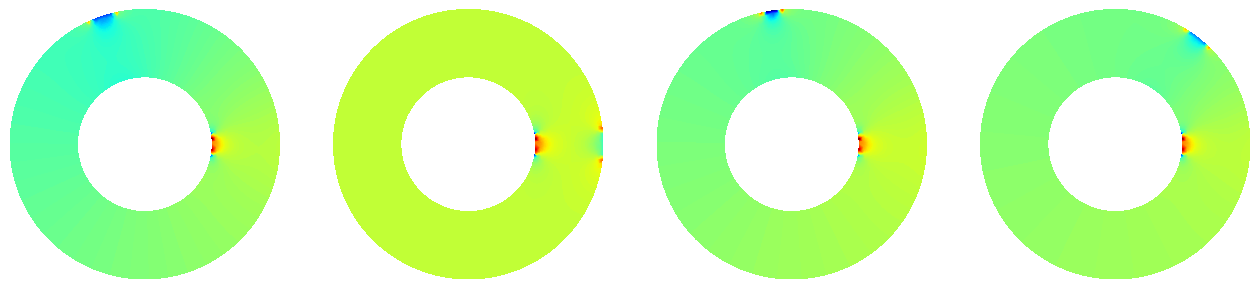

In [51]:
fe.multiplot(pressure[:4], (1, 4), Vh)

In [52]:
l2 = L2(Vh) #funzione che calcola la norma L2
#l2.cuda() #fa la norma l2 sulla GPU
clc()

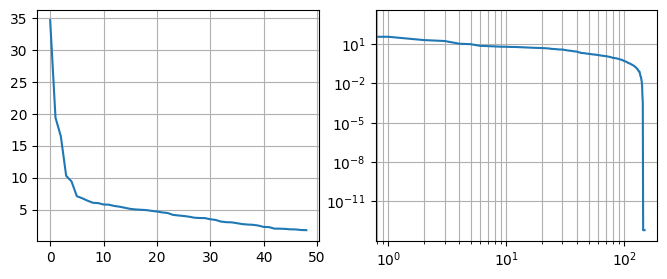

In [53]:
ntrain = 150 #numero di simulazioni che usiamo per il training

from scipy.linalg import svd
X, s, Yt = svd(pressure[:ntrain].T, full_matrices = False)

plt.figure(figsize = (8, 3))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(s[1:50])
plt.subplot(1, 2, 2)
plt.loglog(s)
plt.grid(True, which="both", ls="-")
plt.show()

In [54]:
n=120 #prendiamo 100 RB-basis
V=X[:,:n] #la POD basis sono le prime 100 colonne della singular-left value matrix

In [55]:
print(V.shape)

#compute the projection error
uproj = pressure @ V @ V.T
#relative errors
rerrors=np.linalg.norm(pressure-uproj,axis=1)/np.linalg.norm(pressure,axis=1)
rerrors[ntrain:].mean()

num2p(rerrors[ntrain:].mean()) #projection error (test-set)

(3899, 120)


'0.91%'

In [56]:
c = pressure @ V #espando la soluzione sulla base ridotta: lo spazio V
mu.shape, c.shape

((200, 3), (200, 120))

In [57]:
mu,c=dv.tensor(mu,c)

# Train
+ Regola generale **Train Error** $\le$ 2**Test Error**
+ $\phi:\mu \mapsto c\approx u V$

In [58]:
p=mu.shape[-1]
print(p)
L=500

from torch.optim import Adam
#gelu activation function: un buon compromesso tra expressivity and smoothness!
#architecture= Fourier(fmodes, which=[-1]) + Dense(p+1+2*fmodes, 500, gelu) + Dense(500, L, activation = None)
architecture=Dense(p,L,gelu)+Dense(L,L,gelu)+Dense(L,L,gelu)+Dense(L,n, activation=None)
phi=DFNN(architecture) #produce un trainable model
phi.He() #inizializzazione della NN (Xavier initiator)
phi.cuda()
phi.train(mu,c,ntrain=ntrain,epochs=3000, loss=mse(euclidean),nvalid=30) #loss è la loss-function gestita con MSE e norma euclidea least-square method

		Train		Valid		Test
Epoch 30:	4.07e+01	1.03e+02	4.73e+01.

>> ETA: 38m 24.80s.

Training complete. Elapsed time: 23.41 seconds.


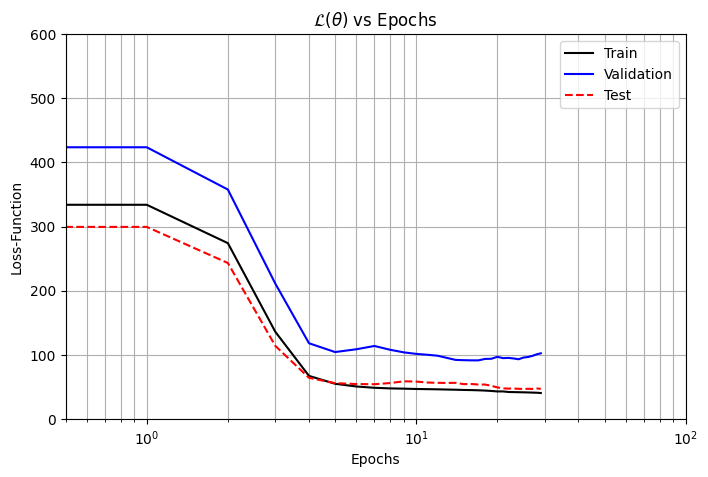

In [59]:
plt.figure(figsize = (8, 5))
plt.title(r'$\mathcal{L}(\theta)$ vs Epochs')
plt.semilogx(phi.errors['Train'], '-k', label = 'Train')
plt.semilogx(phi.errors['Validation'], 'b', label = 'Validation')
plt.semilogx(phi.errors['Test'], '--r', label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Loss-Function')
plt.axis([0.5, 100, 0, 600])
plt.grid(True,which="both", ls="-")
plt.legend()
plt.show()

In [60]:
phi.freeze()

In [61]:
mu[:10].shape, phi(mu[:10]).shape

(torch.Size([10, 3]), torch.Size([10, 120]))

In [62]:
# Ex. 1.5.
import torch
uROM = phi(mu[ntrain:]).cpu() @ V.T #test-set
print("Average relative error (test-set) of POD-NN: %s." % num2p(mre(euclidean)(torch.as_tensor(pressure[ntrain:]), uROM))) #errore: test-set
print(uROM.shape)

Average relative error (test-set) of POD-NN: 11.66%.
torch.Size([50, 3899])


/tmp/ipykernel_5199/1788266568.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  uROM = phi(mu[ntrain:]).cpu() @ V.T #test-set


In [63]:
from time import perf_counter

t0 = perf_counter()
phi(mu[0]).cpu() @ V.T
t1 = perf_counter()
dtROM = t1-t0

import torch
t0 = perf_counter()
mu_aux = torch.cat((mu, mu)) # auxiliary tensor with 1000 different parameter configurations
phi(mu_aux).cpu() @ V.T
t1 = perf_counter()
dtROM1000 = t1-t0


print("POD-NN solver:\t1 call = %.2f ms" % (1000*dtROM)) #1 simulation
print("POD-NN solver:\t1000 calls = %.2f s" % dtROM1000) #1000 simulations

POD-NN solver:	1 call = 6.67 ms
POD-NN solver:	1000 calls = 0.02 s


/tmp/ipykernel_5199/1476813921.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  phi(mu[0]).cpu() @ V.T
/tmp/ipykernel_5199/1476813921.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  phi(mu_aux).cpu() @ V.T


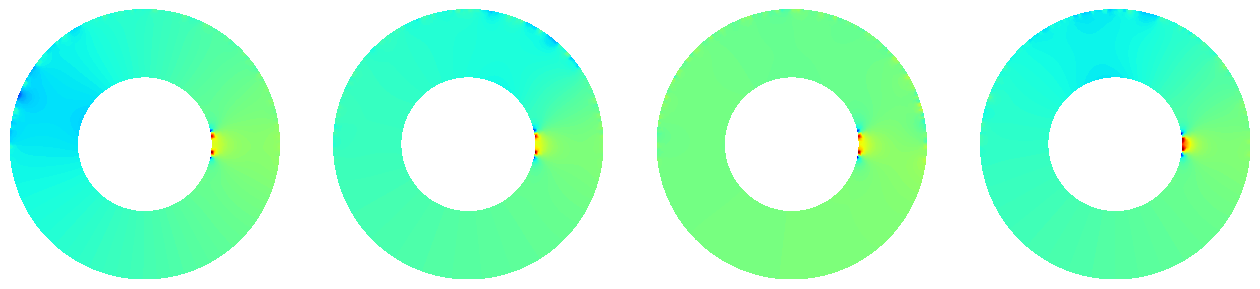

In [64]:
uROM.cpu().numpy().shape
fe.multiplot(uROM[:4], (1, 4), Vh)

+ l'idea ora è calcolare la differenza tra i valori di pressione $s_k$ **calcolati** negli $8$ punti della mesh preselezionati da Rares-Franco, loro sono il *Grand-Truth* ed i valori di pressione calcolati con il modello surrogato $\tilde{p}_{\mu}(k_{i=1\rightarrow 8}\in \mathcal{T_k})$ sugli **stessi** $8$ punti del *Grand-Truth*

/tmp/ipykernel_5199/1759467923.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  uROM_full=phi(mu).cpu() @ V.T


torch.Size([200, 8])


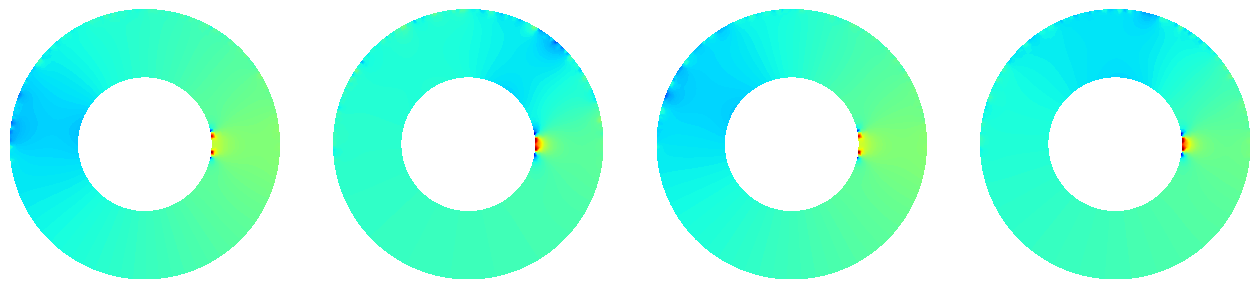

In [65]:
uROM_full=phi(mu).cpu() @ V.T
fe.multiplot(uROM_full[4:8], (1, 4), Vh)
u_sensors = uROM_full[:, sensors_location]
print(u_sensors.shape)

In [66]:
lsp=(np.abs((possible_values-u_sensors.cpu().numpy()))**2).sum(axis=1)
print(lsp.shape)

(200,)


0.8124653623236268
0


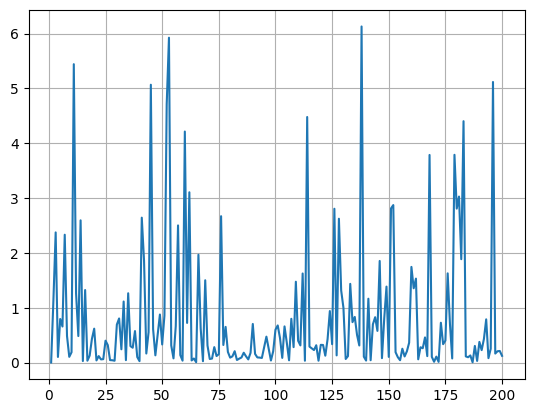

In [67]:
x=np.linspace(1,200,200)
plt.plot(x,lsp)
plt.grid()
print(np.mean(lsp))
print(np.argmin(lsp))